In [25]:
import torch
import torch.nn as nn
from torch.nn import Module, Conv2d, Linear, ReLU, BatchNorm2d,AdaptiveAvgPool2d, MaxPool2d
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm

In [26]:
data_path = "../../DATASETS/classification_datasets/Animals"
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
# Params
epochs = 50
learning_rate = 3e-4
batch_size = 16
num_classes = 10

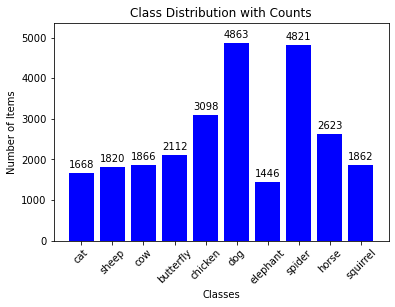

In [27]:
classes = os.listdir(data_path)
dist_dict = {}
for class_name in classes:
    single_class_path = os.path.join(data_path, class_name)
    num_files = len(os.listdir(single_class_path))
    dist_dict[class_name] = num_files

counts = list(dist_dict.values())
fig, ax = plt.subplots()
bars = plt.bar(classes, counts, color='blue')

# Add annotations on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.ylabel('Number of Items')
plt.title('Class Distribution with Counts')

# Adjust y-axis limits
max_count = max(counts)
plt.ylim(0, max_count + 500)  # Increase the upper limit by 200 or adjust as needed

plt.show()

In [28]:
class AnimalsDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        super(AnimalsDataset).__init__()
        self.data_path = data_path
        self.transforms = transforms
        self.classes = os.listdir(data_path)

        my_dict = {}
        my_list = []

        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(self.data_path, class_name)
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                my_dict[file_path] = i
                my_list.append(file_path)
        self.images = my_list
        self.targets = my_dict

        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.targets[image_path]
        image = Image.open(image_path).convert('RGB')

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label

In [29]:
my_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()])

my_dataset = AnimalsDataset(data_path, my_transforms)
train_set = int(0.8*len(my_dataset))
test_set = len(my_dataset) - train_set

train_data, test_data = torch.utils.data.random_split(my_dataset, [train_set, test_set])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=4)

In [30]:
class ResPair(nn.Module):
    def __init__(self, in_channels, out_channels, dim_decrease = False):
        super(ResPair, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim_decrease = dim_decrease

        if self.dim_decrease:
            stride = 2
            self.res = Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride = 2, padding = 0)
        else:
            stride = 1
            self.res = nn.Identity() 

        self.relu = nn.ReLU()
        self.conv1 = nn.Sequential(
            Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size = 3, padding = 1, stride = stride),
            BatchNorm2d(out_channels),
            self.relu)
        
        self.conv2 = nn.Sequential(
            Conv2d(in_channels=out_channels, out_channels = out_channels, kernel_size = 3, padding = 1, stride = 1),
            BatchNorm2d(out_channels))

        

    def forward(self, x):
        y = self.conv1(x)
        z = self.conv2(y)
        out = self.relu(self.res(x)+z)
        return out
        

In [31]:
class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.num_classes = num_classes
        self.conv1 = Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.block1 = nn.Sequential(*[ResPair(64, 64, False), ResPair(64, 64, False), ResPair(64, 64, False)])
        self.block2 = nn.Sequential(*[ResPair(64, 128, True), ResPair(128, 128, False), ResPair(128, 128, False), ResPair(128, 128, False)])
        self.block3 = nn.Sequential(*[ResPair(128, 256, True), ResPair(256, 256, False), ResPair(256, 256, False), ResPair(256, 256, False), ResPair(256, 256, False), ResPair(256, 256, False)])
        self.block4 = nn.Sequential(*[ResPair(256, 512, True), ResPair(512, 512, False), ResPair(512, 512, False)])

        
        self.avgp = nn.AvgPool2d(kernel_size=3)
        self.fc = nn.Linear(512*2*2, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgp(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

In [32]:
x = torch.randn(16, 3, 224, 224).to(device)
model = ResNet34(10).to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


In [33]:
model = ResNet34(num_classes).to(device)

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [35]:
def trainEpoch(device, model, loader, optimizer, criterion):
    loop = tqdm(loader)
    model.train()
    
    losses = []
    correct = 0
    total = 0
    
    for batch_id, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        model = model.to(device)
        
        output = model(images)
        
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        batch_correct = (predicted==labels).sum().item()
        batch_acc = 100*batch_correct/labels.size(0)
        correct += batch_correct
        
        loss = criterion(output, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_postfix(train_loss = loss.item(), train_accuracy = batch_acc)
        
    return np.mean(losses), 100*correct/total

def testEpoch(device, model, loader, criterion):
    model.eval()
    with torch.no_grad():
        losses = []
        correct = 0
        total = 0
        
        loop = tqdm(loader)
        for batch_id, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
            
            output = model(images)
            
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            batch_correct = (predicted==labels).sum().item()
            batch_acc = 100*batch_correct/labels.size(0)
            correct += batch_correct
            
            loss = criterion(output, labels)
            losses.append(loss.item())
            loop.set_postfix(test_loss = loss.item(), test_accuracy = batch_acc)

        return np.mean(losses), 100*correct/total

In [36]:
import copy
last_best = 0
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range (epochs):
    
    train_loss, train_accuracy = trainEpoch(device, model, train_loader, optimizer, criterion)
    test_loss, test_accuracy = testEpoch(device, model, test_loader, criterion)

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)

    if last_best <= test_accuracy:
        torch.save(copy.deepcopy(model.state_dict()), 'resnet34_animals.pt')
        print("Saving new Best Model!")
        last_best = test_accuracy

    print(f"Epoch-{epoch+1} Train Loss: {train_losses[-1]:.4f} Train Accuracy: {train_acc[-1]:.4f}")
    print(f"Epoch-{epoch+1} Test Loss: {test_losses[-1]:.4f} Test Accuracy: {test_acc[-1]:.4f}")

dict = {'train_loss': train_losses, 'train_accuracy': train_acc, 'test_loss': test_losses, 'test_accuracy': test_acc}
df = pd.DataFrame(dict)
df.to_csv('loss_and_acc_resnet34.csv')

100%|██████████| 328/328 [00:14<00:00, 23.01it/s, test_accuracy=25, test_loss=1.6]   


Saving new Best Model!
Epoch-1 Train Loss: 2.0043 Train Accuracy: 30.7454
Epoch-1 Test Loss: 2.4876 Test Accuracy: 21.2567


100%|██████████| 328/328 [00:14<00:00, 22.84it/s, test_accuracy=25, test_loss=1.49]   


Saving new Best Model!
Epoch-2 Train Loss: 1.6873 Train Accuracy: 41.3121
Epoch-2 Test Loss: 1.6527 Test Accuracy: 43.2391


100%|██████████| 328/328 [00:13<00:00, 24.61it/s, test_accuracy=75, test_loss=0.713]  


Saving new Best Model!
Epoch-3 Train Loss: 1.4917 Train Accuracy: 48.4410
Epoch-3 Test Loss: 1.3863 Test Accuracy: 52.5592


100%|██████████| 328/328 [00:13<00:00, 24.55it/s, test_accuracy=50, test_loss=1.14]   


Saving new Best Model!
Epoch-4 Train Loss: 1.3602 Train Accuracy: 53.5453
Epoch-4 Test Loss: 1.3044 Test Accuracy: 56.3216


100%|██████████| 328/328 [00:13<00:00, 24.22it/s, test_accuracy=0, test_loss=2.04]    


Epoch-5 Train Loss: 1.2427 Train Accuracy: 57.5467
Epoch-5 Test Loss: 1.5578 Test Accuracy: 49.7708


100%|██████████| 328/328 [00:14<00:00, 23.43it/s, test_accuracy=50, test_loss=1.32]   


Saving new Best Model!
Epoch-6 Train Loss: 1.1420 Train Accuracy: 61.3618
Epoch-6 Test Loss: 1.2101 Test Accuracy: 58.5752


100%|██████████| 328/328 [00:13<00:00, 23.96it/s, test_accuracy=25, test_loss=1.94]   


Saving new Best Model!
Epoch-7 Train Loss: 1.0511 Train Accuracy: 64.1885
Epoch-7 Test Loss: 1.2381 Test Accuracy: 59.6639


100%|██████████| 328/328 [00:13<00:00, 23.85it/s, test_accuracy=25, test_loss=2.3]    


Saving new Best Model!
Epoch-8 Train Loss: 0.9769 Train Accuracy: 66.5759
Epoch-8 Test Loss: 1.0152 Test Accuracy: 66.9022


100%|██████████| 328/328 [00:14<00:00, 23.17it/s, test_accuracy=50, test_loss=2.01]   


Saving new Best Model!
Epoch-9 Train Loss: 0.9138 Train Accuracy: 69.2260
Epoch-9 Test Loss: 0.9011 Test Accuracy: 70.3400


100%|██████████| 328/328 [00:13<00:00, 24.33it/s, test_accuracy=50, test_loss=1.24]   


Epoch-10 Train Loss: 0.8557 Train Accuracy: 71.1455
Epoch-10 Test Loss: 1.1089 Test Accuracy: 64.6295


100%|██████████| 328/328 [00:14<00:00, 23.40it/s, test_accuracy=50, test_loss=0.898]  


Epoch-11 Train Loss: 0.7992 Train Accuracy: 73.0411
Epoch-11 Test Loss: 1.1524 Test Accuracy: 63.1589


100%|██████████| 328/328 [00:14<00:00, 23.41it/s, test_accuracy=100, test_loss=0.372] 


Saving new Best Model!
Epoch-12 Train Loss: 0.7635 Train Accuracy: 74.2348
Epoch-12 Test Loss: 0.7961 Test Accuracy: 73.5294


100%|██████████| 328/328 [00:14<00:00, 23.15it/s, test_accuracy=100, test_loss=0.48]  


Saving new Best Model!
Epoch-13 Train Loss: 0.7144 Train Accuracy: 76.0827
Epoch-13 Test Loss: 0.7408 Test Accuracy: 75.8976


100%|██████████| 328/328 [00:14<00:00, 22.86it/s, test_accuracy=50, test_loss=1.02]   


Epoch-14 Train Loss: 0.6828 Train Accuracy: 77.1905
Epoch-14 Test Loss: 0.7405 Test Accuracy: 75.4011


100%|██████████| 328/328 [00:14<00:00, 22.64it/s, test_accuracy=75, test_loss=0.727]  


Saving new Best Model!
Epoch-15 Train Loss: 0.6503 Train Accuracy: 78.2075
Epoch-15 Test Loss: 0.7121 Test Accuracy: 76.5852


100%|██████████| 328/328 [00:13<00:00, 24.24it/s, test_accuracy=75, test_loss=0.855]  


Saving new Best Model!
Epoch-16 Train Loss: 0.6198 Train Accuracy: 79.1338
Epoch-16 Test Loss: 0.7159 Test Accuracy: 76.8717


100%|██████████| 328/328 [00:13<00:00, 23.62it/s, test_accuracy=75, test_loss=0.36]   


Saving new Best Model!
Epoch-17 Train Loss: 0.5952 Train Accuracy: 79.6973
Epoch-17 Test Loss: 0.6683 Test Accuracy: 78.1895


100%|██████████| 328/328 [00:13<00:00, 23.63it/s, test_accuracy=50, test_loss=1.8]    


Saving new Best Model!
Epoch-18 Train Loss: 0.5635 Train Accuracy: 80.9531
Epoch-18 Test Loss: 0.6430 Test Accuracy: 79.4500


100%|██████████| 328/328 [00:13<00:00, 25.23it/s, test_accuracy=100, test_loss=0.188] 


Epoch-19 Train Loss: 0.5494 Train Accuracy: 81.6597
Epoch-19 Test Loss: 0.6485 Test Accuracy: 78.5523


100%|██████████| 328/328 [00:15<00:00, 20.95it/s, test_accuracy=50, test_loss=0.856]  


Saving new Best Model!
Epoch-20 Train Loss: 0.5251 Train Accuracy: 82.3951
Epoch-20 Test Loss: 0.6157 Test Accuracy: 79.8319


100%|██████████| 328/328 [00:16<00:00, 20.35it/s, test_accuracy=75, test_loss=0.637]  


Epoch-21 Train Loss: 0.5019 Train Accuracy: 83.2927
Epoch-21 Test Loss: 0.7098 Test Accuracy: 77.8457


100%|██████████| 328/328 [00:14<00:00, 22.03it/s, test_accuracy=100, test_loss=0.0316]


Epoch-22 Train Loss: 0.4820 Train Accuracy: 83.7941
Epoch-22 Test Loss: 0.6283 Test Accuracy: 79.3354


100%|██████████| 328/328 [00:13<00:00, 24.18it/s, test_accuracy=75, test_loss=0.409]  


Saving new Best Model!
Epoch-23 Train Loss: 0.4680 Train Accuracy: 84.0710
Epoch-23 Test Loss: 0.6084 Test Accuracy: 80.1566


100%|██████████| 328/328 [00:15<00:00, 20.54it/s, test_accuracy=100, test_loss=0.159] 


Saving new Best Model!
Epoch-24 Train Loss: 0.4539 Train Accuracy: 84.7921
Epoch-24 Test Loss: 0.5642 Test Accuracy: 81.9710


100%|██████████| 328/328 [00:14<00:00, 22.06it/s, test_accuracy=100, test_loss=0.0947]


Epoch-25 Train Loss: 0.4363 Train Accuracy: 85.6372
Epoch-25 Test Loss: 0.6007 Test Accuracy: 80.3667


100%|██████████| 328/328 [00:15<00:00, 20.92it/s, test_accuracy=100, test_loss=0.166] 


Epoch-26 Train Loss: 0.4247 Train Accuracy: 85.8855
Epoch-26 Test Loss: 0.5754 Test Accuracy: 81.9137


100%|██████████| 328/328 [00:15<00:00, 20.63it/s, test_accuracy=100, test_loss=0.0287] 


Saving new Best Model!
Epoch-27 Train Loss: 0.4063 Train Accuracy: 86.4489
Epoch-27 Test Loss: 0.5471 Test Accuracy: 82.1620


100%|██████████| 328/328 [00:14<00:00, 22.53it/s, test_accuracy=100, test_loss=0.0104]


Saving new Best Model!
Epoch-28 Train Loss: 0.3961 Train Accuracy: 86.6972
Epoch-28 Test Loss: 0.5520 Test Accuracy: 82.3720


100%|██████████| 328/328 [00:14<00:00, 22.30it/s, test_accuracy=100, test_loss=0.0437]


Epoch-29 Train Loss: 0.3785 Train Accuracy: 87.3800
Epoch-29 Test Loss: 0.6174 Test Accuracy: 80.6341


100%|██████████| 328/328 [00:15<00:00, 21.47it/s, test_accuracy=75, test_loss=1.4]     


Saving new Best Model!
Epoch-30 Train Loss: 0.3667 Train Accuracy: 87.7190
Epoch-30 Test Loss: 0.4888 Test Accuracy: 84.1673


100%|██████████| 328/328 [00:14<00:00, 22.43it/s, test_accuracy=75, test_loss=0.334]  


Epoch-31 Train Loss: 0.3523 Train Accuracy: 88.3828
Epoch-31 Test Loss: 0.5239 Test Accuracy: 83.6516


100%|██████████| 328/328 [00:14<00:00, 22.32it/s, test_accuracy=100, test_loss=0.148] 


Epoch-32 Train Loss: 0.3435 Train Accuracy: 88.4592
Epoch-32 Test Loss: 0.5916 Test Accuracy: 82.4102


100%|██████████| 328/328 [00:15<00:00, 20.79it/s, test_accuracy=75, test_loss=0.408]   


Epoch-33 Train Loss: 0.3376 Train Accuracy: 88.6645
Epoch-33 Test Loss: 0.5152 Test Accuracy: 83.3843


100%|██████████| 328/328 [00:15<00:00, 20.63it/s, test_accuracy=100, test_loss=0.0418] 


Epoch-34 Train Loss: 0.3185 Train Accuracy: 89.2327
Epoch-34 Test Loss: 0.6262 Test Accuracy: 81.3216


100%|██████████| 328/328 [00:15<00:00, 20.97it/s, test_accuracy=75, test_loss=0.8]    


Saving new Best Model!
Epoch-35 Train Loss: 0.3173 Train Accuracy: 89.3234
Epoch-35 Test Loss: 0.5099 Test Accuracy: 84.4156


100%|██████████| 328/328 [00:16<00:00, 20.06it/s, test_accuracy=100, test_loss=0.0532] 


Epoch-36 Train Loss: 0.2991 Train Accuracy: 89.8868
Epoch-36 Test Loss: 0.5256 Test Accuracy: 83.8044


100%|██████████| 328/328 [00:15<00:00, 21.41it/s, test_accuracy=75, test_loss=0.656]   


Epoch-37 Train Loss: 0.2989 Train Accuracy: 89.8343
Epoch-37 Test Loss: 0.5184 Test Accuracy: 84.2246


100%|██████████| 328/328 [00:15<00:00, 21.03it/s, test_accuracy=50, test_loss=0.845]   


Saving new Best Model!
Epoch-38 Train Loss: 0.2823 Train Accuracy: 90.5887
Epoch-38 Test Loss: 0.4945 Test Accuracy: 84.6639


100%|██████████| 328/328 [00:15<00:00, 20.94it/s, test_accuracy=75, test_loss=0.454]   


Epoch-39 Train Loss: 0.2832 Train Accuracy: 90.4885
Epoch-39 Test Loss: 0.5200 Test Accuracy: 84.3774


100%|██████████| 328/328 [00:15<00:00, 21.06it/s, test_accuracy=50, test_loss=0.894]   


Saving new Best Model!
Epoch-40 Train Loss: 0.2689 Train Accuracy: 90.9803
Epoch-40 Test Loss: 0.4737 Test Accuracy: 85.5806


100%|██████████| 328/328 [00:14<00:00, 22.07it/s, test_accuracy=100, test_loss=0.0106] 


Epoch-41 Train Loss: 0.2561 Train Accuracy: 91.4243
Epoch-41 Test Loss: 0.5038 Test Accuracy: 85.0840


100%|██████████| 328/328 [00:14<00:00, 21.96it/s, test_accuracy=50, test_loss=0.639]  


Saving new Best Model!
Epoch-42 Train Loss: 0.2537 Train Accuracy: 91.8159
Epoch-42 Test Loss: 0.4753 Test Accuracy: 85.5806


100%|██████████| 328/328 [00:16<00:00, 20.36it/s, test_accuracy=75, test_loss=0.598]   


Saving new Best Model!
Epoch-43 Train Loss: 0.2541 Train Accuracy: 91.5103
Epoch-43 Test Loss: 0.4433 Test Accuracy: 86.9175


100%|██████████| 328/328 [00:16<00:00, 19.64it/s, test_accuracy=100, test_loss=0.0735] 


Epoch-44 Train Loss: 0.2346 Train Accuracy: 92.1358
Epoch-44 Test Loss: 0.4713 Test Accuracy: 86.2299


100%|██████████| 328/328 [00:14<00:00, 22.27it/s, test_accuracy=50, test_loss=2.07]    


Epoch-45 Train Loss: 0.2377 Train Accuracy: 91.9973
Epoch-45 Test Loss: 0.5937 Test Accuracy: 83.3079


100%|██████████| 328/328 [00:15<00:00, 21.46it/s, test_accuracy=100, test_loss=0.041]  


Epoch-46 Train Loss: 0.2298 Train Accuracy: 92.1979
Epoch-46 Test Loss: 0.5966 Test Accuracy: 82.3529


100%|██████████| 328/328 [00:16<00:00, 20.47it/s, test_accuracy=100, test_loss=0.000489]


Epoch-47 Train Loss: 0.2202 Train Accuracy: 92.5417
Epoch-47 Test Loss: 0.4677 Test Accuracy: 86.4018


100%|██████████| 328/328 [00:14<00:00, 21.89it/s, test_accuracy=50, test_loss=1.25]    


Epoch-48 Train Loss: 0.2228 Train Accuracy: 92.3316
Epoch-48 Test Loss: 0.4912 Test Accuracy: 84.9121


100%|██████████| 328/328 [00:15<00:00, 21.76it/s, test_accuracy=75, test_loss=1.42]    


Epoch-49 Train Loss: 0.2162 Train Accuracy: 92.5799
Epoch-49 Test Loss: 0.4678 Test Accuracy: 86.3636


100%|██████████| 328/328 [00:14<00:00, 21.98it/s, test_accuracy=100, test_loss=0.0638] 


Saving new Best Model!
Epoch-50 Train Loss: 0.2127 Train Accuracy: 92.9809
Epoch-50 Test Loss: 0.4363 Test Accuracy: 87.2040


In [37]:
train_loss = df["train_loss"]
train_acc = df["train_accuracy"]
valid_loss = df["test_loss"]
valid_acc = df["test_accuracy"]

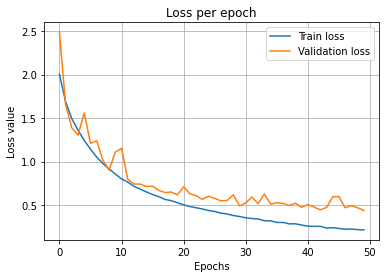

In [38]:
plt.plot(train_loss, label="Train loss")
plt.plot(valid_loss, label="Validation loss")
plt.title("Loss per epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.legend()
plt.grid()
plt.show()

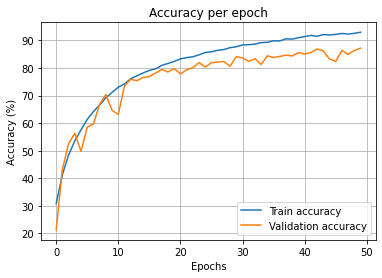

In [39]:
plt.plot(train_acc, label="Train accuracy")
plt.plot(valid_acc, label="Validation accuracy")
plt.title("Accuracy per epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

In [40]:
# Now, let's load the trained model
model = ResNet34(num_classes=num_classes)
model.load_state_dict(torch.load("resnet34_animals.pt"))

<All keys matched successfully>

In [41]:
correct = 0
total = 0
model = model.to(device)
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    model.eval()
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
       
        
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

100%|██████████| 328/328 [00:14<00:00, 23.03it/s]

Accuracy of the network on the test images: 86 %


In [42]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        model=model.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

100%|██████████| 328/328 [00:14<00:00, 22.05it/s]

Accuracy for class: cat   is 83.0 %
Accuracy for class: sheep is 84.8 %
Accuracy for class: cow   is 78.3 %
Accuracy for class: butterfly is 87.6 %
Accuracy for class: chicken is 87.8 %
Accuracy for class: dog   is 89.9 %
Accuracy for class: elephant is 89.6 %
Accuracy for class: spider is 90.9 %
Accuracy for class: horse is 86.3 %
Accuracy for class: squirrel is 87.7 %


In [43]:
def show_images(images, true_labels, predicted_labels, nrows, ncols, classes):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        # Convert the tensor image to a NumPy array
        img = images[i]
        img = transforms.ToPILImage()(img)
        true_label = classes[true_labels[i]]
        predicted_label = classes[predicted_labels[i]]

        # Display the image
        ax.imshow(img)

        # Display the label below the image
        if true_label == predicted_label:
            font_color  = "green"
        else:
            font_color = "red"
        ax.set_xlabel(f"GT: {true_label} | Predicted: {predicted_label}", color=font_color)

        # Remove ticks and labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_facecolor("white")

    plt.tight_layout()
    plt.show()

In [44]:
images, true_labels = next(iter(test_loader))
images = images.to(device)
model = model.to(device)
outputs = model(images)
_, predicted_labels = torch.max(outputs.data, 1)
true_labels = true_labels.numpy()
predicted_labels = predicted_labels.cpu().detach().numpy()

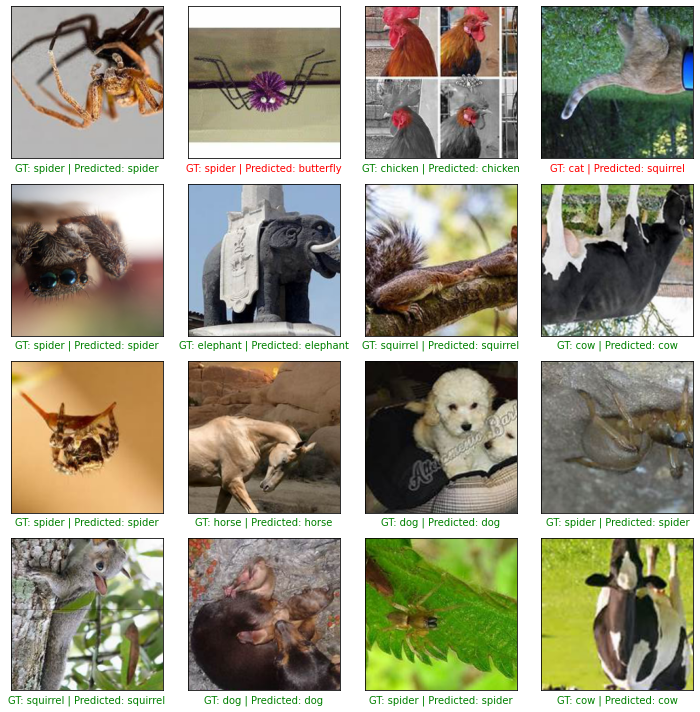

In [45]:
show_images(images, true_labels, predicted_labels, 4,4, classes)